[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This is an updated version of our [how-to-track-and-count-vehicles-with-yolov8](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8.ipynb) notebook, using the latest [supervision](https://github.com/roboflow/supervision) APIs.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Apr 15 12:22:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P5             20W /  130W |    2870MiB /   8192MiB |     50%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\ignac\Documents\ipre_ciclistas


## Install YOLOv8

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [3]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.47  Python-3.12.3 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3050, 8192MiB)
Setup complete  (32 CPUs, 31.8 GB RAM, 421.5/930.7 GB disk)


## Install Roboflow Supervision

In [4]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.19.0


## Load pre-trained YOLOv8 model

In [5]:
MODEL = "yolov8x.pt"

In [6]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients


## Predict and annotate single frame

In [7]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [1]

### Check working

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


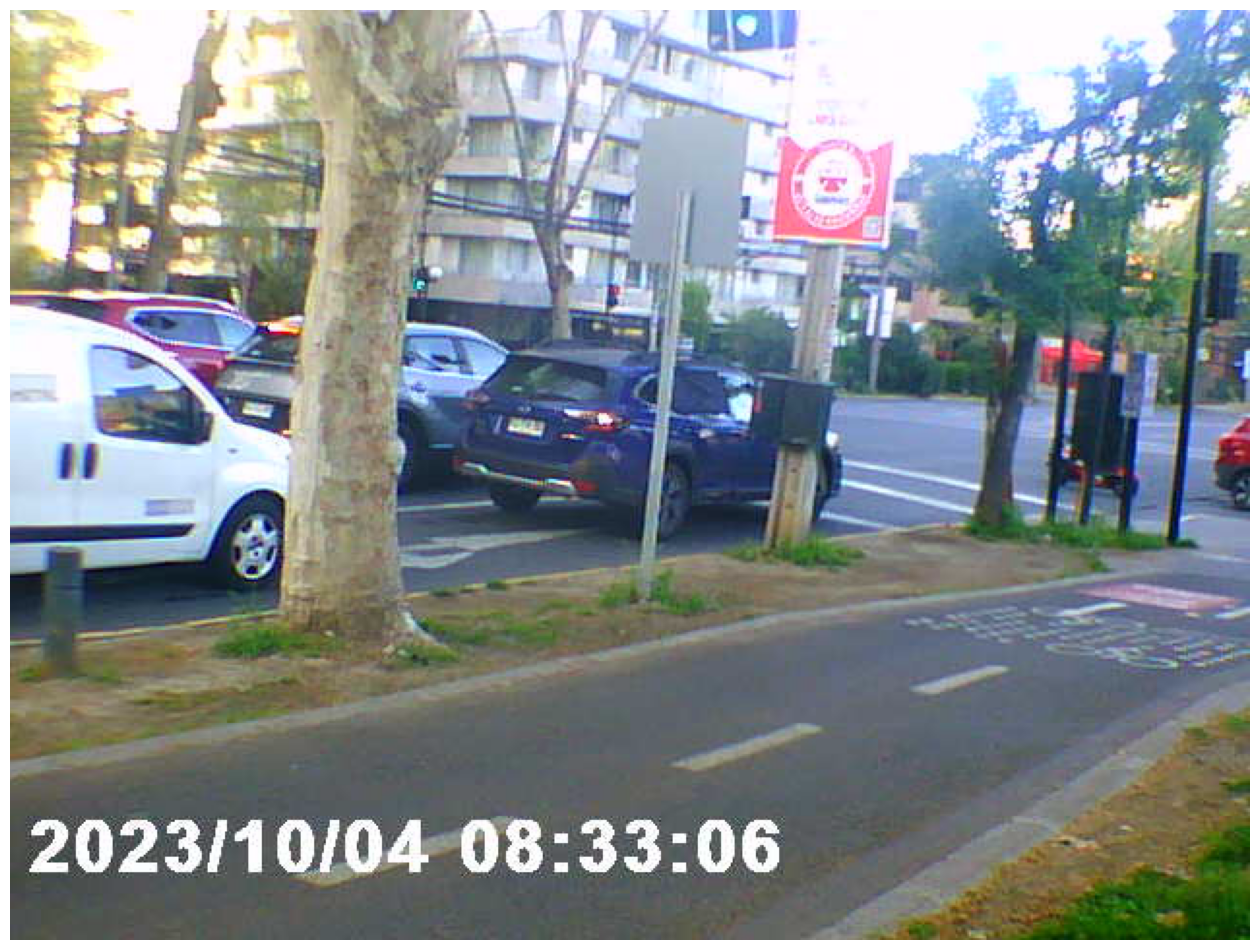

In [9]:
import VARIABLES2
import importlib

# Reload the module
importlib.reload(VARIABLES2)

# Now you can access the updated variables
from VARIABLES2 import *
import numpy as np

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision    Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

## Predict and annotate whole video

#### Redefinition process video

In [10]:

def process_video(
    source_path: str,
    target_path: str,
    callback,
    stride=1,
) -> None:
    """
    Process a video file by applying a callback function on each frame
        and saving the result to a target video file.

    Args:
        source_path (str): The path to the source video file.
        target_path (str): The path to the target video file.
        callback (Callable[[np.ndarray, int], np.ndarray]): A function that takes in
            a numpy ndarray representation of a video frame and an
            int index of the frame and returns a processed numpy ndarray
            representation of the frame.

    Examples:
        ```python
        import supervision as sv

        def callback(scene: np.ndarray, index: int) -> np.ndarray:
            ...

        process_video(
            source_path=<SOURCE_VIDEO_PATH>,
            target_path=<TARGET_VIDEO_PATH>,
            callback=callback
        )
        ```
    """
    source_video_info = sv.VideoInfo.from_video_path(video_path=source_path)
    with sv.VideoSink(target_path=target_path, video_info=source_video_info) as sink:
        for index, frame in enumerate(
            sv.get_video_frames_generator(source_path=source_path, stride=stride)
        ):
            result_frame = callback(frame, index)
            sink.write_frame(frame=result_frame)

In [11]:
import torch
import math 

import supervision as sv
import numpy as np
import importlib
import VARIABLES2

# Reload the module
importlib.reload(VARIABLES2)

# Now you can access the updated variables
from VARIABLES2 import *
print(SOURCE_VIDEO_PATH)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

def calculate_hypotenuse(a, b):
    return math.sqrt(a**2 + b**2)
video_default_size = calculate_hypotenuse(1920, 1080)
video_current_size = calculate_hypotenuse(video_info.width, video_info.height)
proportion = video_current_size / video_default_size

# Video annotations params, proportional to video size
va_params = {
  "thickness": round(THICKNESS_DEFAULT * proportion),
  "text_thickness": round(TEXT_THICKNESS_DEFAULT * proportion),
  "text_scale": TEXT_SCALE_DEFAULT * proportion,
  "trace_length": round(TRACE_LENGTH_DEFAULT * proportion),
}

# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25, lost_track_buffer=150, minimum_matching_threshold=0.8, frame_rate=video_info.fps
)



# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=va_params["thickness"], text_thickness=va_params["text_thickness"], text_scale=va_params["text_scale"])

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=va_params["thickness"], trace_length=va_params["trace_length"])


# settings
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

line_zones = []
for i in [-1, 0, 1]:
    x = video_info.width * (1 / 2 + i * 0.15)
    line_zones.append(
        sv.LineZone(
        start=sv.Point( x, 0),
        end=sv.Point(x, video_info.height)
        )
    )


# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
# line_zone_annotator = sv.LineZoneAnnotator(thickness=va_params["thickness"], text_thickness=va_params["text_thickness"], text_scale=va_params["text_scale"])
line_zone_annotators = [
    sv.LineZoneAnnotator(
        thickness=va_params["thickness"],
        text_thickness=va_params["text_thickness"],
        text_scale=va_params["text_scale"]
        )
    for _ in range(3)]

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False, device=torch.device("cuda:0"))[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above 
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # update line counter
    for line_zone in line_zones:
        line_zone.trigger(detections)
    # return frame with box and line annotated result
    for i in range(3):
        annotated_frame = line_zone_annotators[i].annotate(annotated_frame, line_counter=line_zones[i])
    return  annotated_frame

sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback,
)

video_shorts\MOVI0016-short2.avi


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


KeyboardInterrupt: 

In [12]:
video_info

VideoInfo(width=640, height=480, fps=30, total_frames=1139)

## Process multiple videos

In [ ]:
import os
import csv
from tqdm import tqdm

def get_lines_zones():
  line_zones = []
  for i in [-1, 0, 1]:
      x = video_info.width * (1 / 2 + i * 0.15)
      line_zones.append(
          sv.LineZone(
          start=sv.Point( x, 0),
          end=sv.Point(x, video_info.height)
          )
      )
  return line_zones


# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
# line_zone_annotator = sv.LineZoneAnnotator(thickness=va_params["thickness"], text_thickness=va_params["text_thickness"], text_scale=va_params["text_scale"])
line_zone_annotators = [
    sv.LineZoneAnnotator(
        thickness=va_params["thickness"],
        text_thickness=va_params["text_thickness"],
        text_scale=va_params["text_scale"]
        )
    for _ in range(3)]


videos_folder = "probando"
videos_folder_path = os.path.join("full_recordings", videos_folder)


data = [["file_name", "in", "out"]]

prev_in, prev_out = 0,  0



with open(os.path.join("results", f"videos_folder.csv"), "w") as csv_output:
  writer = csv.writer(csv_output)
  try:
    for file_name in tqdm(os.listdir(videos_folder_path)):
      file_path = os.path.join(videos_folder_path, file_name)
      lines_zones = get_lines_zones()
      process_video(
        source_path = file_path,
        target_path = TARGET_DUMMY_VIDEO_PATH,
        callback=callback,
      ) 
      max_in = max(line_zones, key=lambda x: x.in_count)
      max_out = max(line_zones, key=lambda x: x.out_count)
      
      data.append([file_name, max_in - prev_in, max_out - prev_out])
      prev_in= max_in  
      prev_out= max_out  
  except Exception as e:
    print(e)
  finally:
    writer.writerows(data)
    print(max_in, max_out)
  

SyntaxError: expected ':' (1105133499.py, line 8)